In [1]:
#Change Runtime type to GPU

!mkdir "/content/dataset"

#Mount Google Drive first!
#Unzip the dataset file and paste to cloab dataset directory.
# !unzip "/content/drive/MyDrive/path-to-zip" -d "/content/dataset"


# Skip this step. Dataset folder in my google drive. 
!unzip "/content/drive/MyDrive/cldds/dataset/cotton-leaf.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/cotton-leaf/fusarium_wilt/fus327.jpg  
  inflating: /content/dataset/__MACOSX/cotton-leaf/fusarium_wilt/._fus327.jpg  
  inflating: /content/dataset/cotton-leaf/fusarium_wilt/fus326.jpg  
  inflating: /content/dataset/__MACOSX/cotton-leaf/fusarium_wilt/._fus326.jpg  
  inflating: /content/dataset/cotton-leaf/fusarium_wilt/fus332.jpg  
  inflating: /content/dataset/__MACOSX/cotton-leaf/fusarium_wilt/._fus332.jpg  
  inflating: /content/dataset/cotton-leaf/fusarium_wilt/g21.jpg  
  inflating: /content/dataset/__MACOSX/cotton-leaf/fusarium_wilt/._g21.jpg  
  inflating: /content/dataset/cotton-leaf/fusarium_wilt/fus124.jpg  
  inflating: /content/dataset/__MACOSX/cotton-leaf/fusarium_wilt/._fus124.jpg  
  inflating: /content/dataset/cotton-leaf/fusarium_wilt/fus130.jpg  
  inflating: /content/dataset/__MACOSX/cotton-leaf/fusarium_wilt/._fus130.jpg  
  inflating: /content/dataset/cotton-leaf/fusarium_wilt/fus11

In [2]:
!rm -rf "/content/dataset/__MACOSX"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
import pathlib
data_dir = "/content/dataset/cotton-leaf/"
data_dir = pathlib.Path(data_dir)


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6434


In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6626 files belonging to 8 classes.
Using 5964 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6626 files belonging to 8 classes.
Using 1987 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['aphids', 'army_worm', 'bacterial_blight', 'curl_virus', 'fusarium_wilt', 'healthy', 'powdery_mildew', 'target_spot']


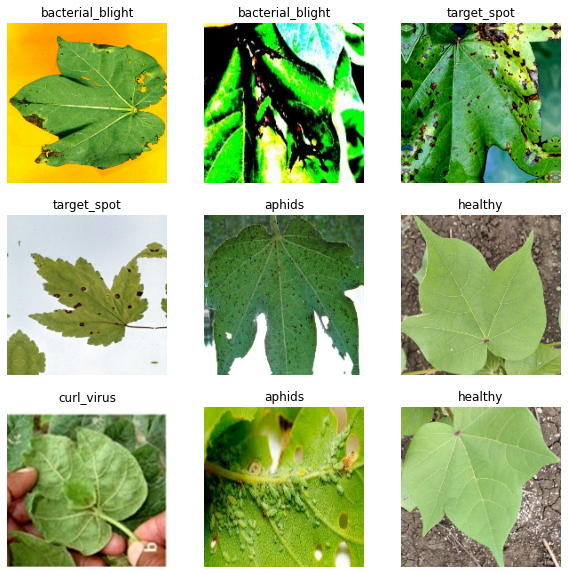

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

#Normalized
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

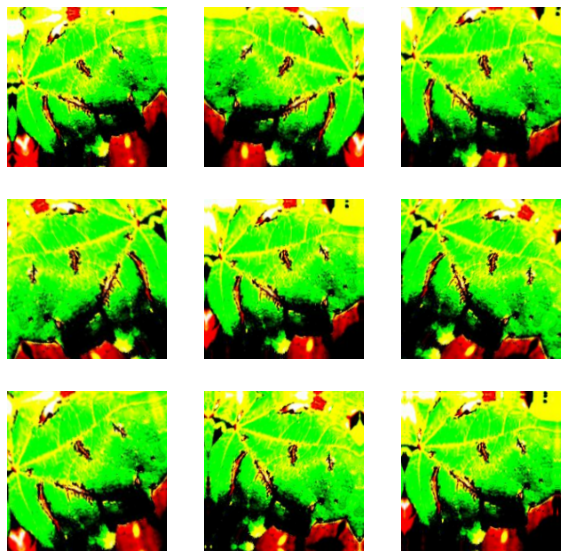

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [22]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25


187/187 [==============================] - 51s 194ms/step - loss: 1.5609 - accuracy: 0.4214 - val_loss: 1.3591 - val_accuracy: 0.5123
Epoch 2/25
187/187 [==============================] - 31s 165ms/step - loss: 1.0717 - accuracy: 0.6112 - val_loss: 1.1728 - val_accuracy: 0.6085
Epoch 3/25
187/187 [==============================] - 32s 170ms/step - loss: 0.8852 - accuracy: 0.6828 - val_loss: 1.0201 - val_accuracy: 0.6804
Epoch 4/25
187/187 [==============================] - 31s 168ms/step - loss: 0.7375 - accuracy: 0.7393 - val_loss: 0.6758 - val_accuracy: 0.7670
Epoch 5/25
187/187 [==============================] - 31s 165ms/step - loss: 0.5670 - accuracy: 0.8052 - val_loss: 0.7258 - val_accuracy: 0.7695
Epoch 6/25
187/187 [==============================] - 30s 162ms/step - loss: 0.5217 - accuracy: 0.8229 - val_loss: 0.5064 - val_accuracy: 0.8359
Epoch 7/25
187/187 [==============================] - 30s 162ms/step - loss: 0.4320 - accuracy: 0.8578 - val_loss: 0.5183 - val_accuracy: 0.8

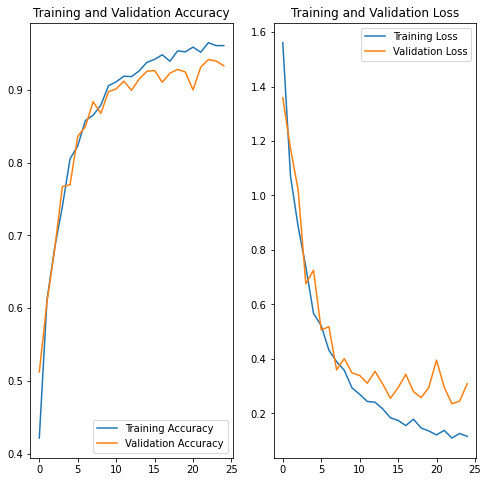

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [26]:
leaf_path = "/content/ar.jpg"

img = tf.keras.utils.load_img(
    leaf_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 19ms/step
This image most likely belongs to army_worm with a 93.03 percent confidence.
